In [5]:

# In this project, I will take play by play data from the 2019-2020 NBA basketball season ...
# ...and train a predictive model that deduces whether a shot -- given a certain context(i.e. Time Remaining, Quarter, Score Margin, Shot Type) --  will ("probably") be made or missed

# install the below libraries in addition to those covered in the lessons


#install nba_api
#install pandas
#install numpy

In [23]:
#initialize our libraries
from nba_api.stats.endpoints import leaguegamefinder, playbyplayv2
import pandas as pd
import time
import numpy as np


# '''
# This notebook will tackle each step subsequently. 
# A function will first be defined and tested. Then verified, executed, and ouputs stored. Then we will move to the next step.

# A general outline is as follows.
# 1. Get a list of games from the specified season -- or their IDs in this case.
# 2. Get the play by play data for the games in that season.
# 3. Extract Relevant data -- Mining
# 4. Manipulate and Model Data
# 5. Train Our Model
# 6. Evaluate Out Model
# '''

In [7]:
# Step 1: Get a list of games for a specific season
#Using the leaguegamefinder endpoint we can retrieve a dataframe of all games in a season
#While this data includes things like final scores and other high-level information, we only want indetifiers so that we can point to specific instances in another separate dataset
#We only return a single column and make sure there are no repeat entries
def get_season_games(season_year='2019-20'):
    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=season_year)
    games_df = gamefinder.get_data_frames()[0]
    return games_df['GAME_ID'].unique()

In [8]:
#Here we are using the previously defined function to store the game IDs and call it to verify it's contents
game_ids = get_season_games('2019-20')
game_ids

array(['0041900406', '0041900405', '0041900404', ..., '0011900004',
       '0011900002', '0011900001'], dtype=object)

In [9]:
#Step 2: Retrieve a dataframe with all play by play 'calls' for all games retrieved
#By iterating over our game_ids array, we can fetch the data for each instance.
#We construct a dataframe with these requests.
def get_play_by_play_data(game_ids):
    all_play_by_play_data = []
    for game_id in game_ids:
        print(game_id)
        try:
            pbp = playbyplayv2.PlayByPlayV2(game_id=game_id)
            pbp_df = pbp.get_data_frames()[0]
            pbp_df['GAME_ID'] = game_id
            all_play_by_play_data.append(pbp_df)
            time.sleep(1)  # To avoid hitting rate limits
        except Exception as e:
            print(f"Error fetching data for game {game_id}: {e}")
    
    combined_df = pd.concat(all_play_by_play_data, ignore_index=True)
    return combined_df

In [10]:
#Here we call the function defined above and store the data.
#Our function prints every game id to notice if our environment freezes or a request times out.
combined_df = get_play_by_play_data(game_ids[:480])

0041900406
0041900405
0041900404
0041900403
0041900402
0041900401
0041900306
0041900315
0041900305
0041900314
0041900304
0041900313
0041900312
0041900303
0041900311
0041900302
0041900237
0041900301
0041900236
0041900225
0041900235
0041900217
0041900224
0041900234
0041900216
0041900223
0041900205
0041900215
0041900233
0041900204
0041900222
0041900232
0041900214
0041900203
0041900221
0041900213
0041900231
0041900202
0041900177
0041900212
0041900167
0041900176
0041900201
0041900156
0041900166
0041900211
0041900175
0041900105
0041900145
0041900155
0041900165
0041900174
0041900144
0041900104
0041900134
0041900124
0041900114
0041900154
0041900164
0041900173
0041900133
0041900103
0041900143
0041900113
0041900123
0041900163
0041900153
0041900172
0041900102
0041900132
0041900142
0041900152
0041900112
0041900122
0041900162
0041900171
0041900101
0041900131
0041900141
0041900161
0041900111
0041900151
0041900121
0051900111
0021901315
0021901317
0021901318
0021901316
0021901312
0021901308
0021901313

In [11]:
#re-store the dataframe to a simpler name
d=combined_df

In [12]:
#Step 3: In order to mine the data we want, we only pull the entries that are made and missed shots
# Our d datafram has several columns, but we want to focus on 5 as we continue to mine/model the data.
#Right now we will focus on 'EVENTMSGTYPE' which maps a variety of number to different court events such as a rebound, steal, foul, and most importantly to us ... shots
#Made shots are mapped to 1 and missed shots are mapped to 2.
#We can extract these events by checking which entries have 1s and 2s in this column
shot_events = d[d['EVENTMSGTYPE'].isin([1, 2])]

In [13]:
#We will print the new data frame to verify successful extraction and explore our data set. Most of it is junk?/fluff?/placeholder...
print(shot_events)

           GAME_ID EVENTNUM EVENTMSGTYPE EVENTMSGACTIONTYPE PERIOD  \
2       0041900406        7            1                  1      1   
3       0041900406        9            1                 52      1   
4       0041900406       11            2                 80      1   
6       0041900406       13            2                  1      1   
8       0041900406       15            2                 79      1   
...            ...      ...          ...                ...    ...   
226549  2021900453      635            2                  5      4   
226551  2021900453      637            1                 79      4   
226553  2021900453      640            1                 75      4   
226555  2021900453      642            1                  1      4   
226561  2021900453      649            2                  5      4   

       WCTIMESTRING PCTIMESTRING  \
2           7:41 PM        11:48   
3           7:41 PM        11:25   
4           7:41 PM        11:11   
6           7:4

In [14]:
#This is an extra step for viewing sake. Here I condence the event descriptions into one column. This makes it easier to identify the mappings of the 'EVENTMSGACTIONTYPES' down the line.
#Cleaning up and further the parsing the data at this point may prove to be helpful in future iterations of this model.
def extract_shot_description(row):
    if pd.notna(row['HOMEDESCRIPTION']) and 'Shot' in row['HOMEDESCRIPTION']:
        return row['HOMEDESCRIPTION']
    elif pd.notna(row['VISITORDESCRIPTION']) and 'Shot' in row['VISITORDESCRIPTION']:
        return row['VISITORDESCRIPTION']
    elif pd.notna(row['NEUTRALDESCRIPTION']) and 'Shot' in row['NEUTRALDESCRIPTION']:
        return row['NEUTRALDESCRIPTION']
    return None

# Apply the function to extract descriptions of shot types
shot_events['SHOT_DESCRIPTION'] = shot_events.apply(extract_shot_description, axis=1)

# Filter out rows where the description is None (i.e., no valid shot description)
shot_events = shot_events[shot_events['SHOT_DESCRIPTION'].notnull()]

/var/folders/c7/tjnc1nv13vl7684g7d2d8thm0000gn/T/ipykernel_4123/53527258.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_events['SHOT_DESCRIPTION'] = shot_events.apply(extract_shot_description, axis=1)


In [15]:
#the following are tests meant to aid in understanding the data and features...

#test 1... what type of shots are being taken --frequency/multiplicty
#each key represent a shot type (i.e. 1: Jump Shot vs 98: Cutting Layup Shot) ... we notices the data is heavily biased
#this further necessitates creating bins and modifiers based on how advanced/difficult a shot it... additionally 3PT jumpshot and a 2PT jumpshot are both represented by 1.
#in our data set there are at least 28 distinct shot types (this does not distinguish between 3PT/2PT shots of the same type i.e. step back, pull up)

sd={}
for i in shot_events['EVENTMSGACTIONTYPE']:
    if i not in sd:
        sd[i]=1
    sd[i]+=1
print(sd)
print(len(sd))

{1: 30019, 80: 3580, 79: 9133, 86: 531, 98: 2075, 47: 1143, 78: 1700, 97: 1552, 102: 1086, 101: 3034, 58: 695, 57: 433, 108: 1239, 3: 836, 103: 588, 99: 312, 106: 69, 96: 61, 2: 745, 105: 214, 66: 289, 93: 75, 107: 271, 100: 27, 67: 46, 104: 23, 109: 29, 110: 6}
28


In [17]:
#test 2 ... elucidate the shot type/description to EVENTMSGACTIONTYPE mappings
for k in range(20):
    for j in sd:
        if j == shot_events['EVENTMSGACTIONTYPE'].iloc[k]:      
            print(j, '     ', shot_events['EVENTMSGTYPE'].iloc[k],'      ',shot_events['SHOT_DESCRIPTION'].iloc[k])

1       1        Davis 18' Jump Shot (2 PTS) (James 1 AST)
80       2        MISS Davis 16' Step Back Jump Shot
1       2        MISS Robinson 3PT Jump Shot
79       2        MISS Caldwell-Pope 19' Pullup Jump Shot
86       2        MISS Davis 11' Turnaround Fadeaway Shot
79       2        MISS Herro 15' Pullup Jump Shot
79       2        MISS Green 24' 3PT Pullup Jump Shot
98       2        MISS Adebayo 3' Cutting Layup Shot
1       1        Robinson 26' 3PT Jump Shot (3 PTS) (Butler 1 AST)
1       2        MISS James 27' 3PT Jump Shot
47       2        MISS Butler 6' Turnaround Jump Shot
1       1        Robinson 28' 3PT Jump Shot (6 PTS) (Herro 2 AST)
1       2        MISS Green 26' 3PT Jump Shot
1       1        Green 24' 3PT Jump Shot (3 PTS) (Davis 1 AST)
78       2        MISS Adebayo 10' Floating Jump Shot
98       1        Herro 2' Cutting Layup Shot (2 PTS) (Butler 2 AST)
1       2        MISS Caldwell-Pope 25' 3PT Jump Shot
1       2        MISS Crowder 27' 3PT Jump Shot
98 

In [18]:
#test 3 ... display other relevant data
# this includes the columns 'PERIOD','PCTIMESTRING','SCOREMARGIN'
#here we notice that our play clock and score margin provide crucial timeseries data but might need to be transformed in order to be incorporated into our model

for k in range(50):
    for j in sd:
        if j == shot_events['EVENTMSGACTIONTYPE'].iloc[k]:
            print(shot_events['EVENTMSGTYPE'].iloc[k], '     ',j, '     ', shot_events['PERIOD'].iloc[k],'      ',shot_events['PCTIMESTRING'].iloc[k] ,'      ',shot_events['SCOREMARGIN'].iloc[k] ,'      ',shot_events['SHOT_DESCRIPTION'].iloc[k])

1       1       1        11:48        -2        Davis 18' Jump Shot (2 PTS) (James 1 AST)
2       80       1        11:11        None        MISS Davis 16' Step Back Jump Shot
2       1       1        11:02        None        MISS Robinson 3PT Jump Shot
2       79       1        10:53        None        MISS Caldwell-Pope 19' Pullup Jump Shot
2       86       1        10:17        None        MISS Davis 11' Turnaround Fadeaway Shot
2       79       1        9:48        None        MISS Herro 15' Pullup Jump Shot
2       79       1        9:42        None        MISS Green 24' 3PT Pullup Jump Shot
2       98       1        9:28        None        MISS Adebayo 3' Cutting Layup Shot
1       1       1        9:08        -1        Robinson 26' 3PT Jump Shot (3 PTS) (Butler 1 AST)
2       1       1        8:31        None        MISS James 27' 3PT Jump Shot
2       47       1        7:56        None        MISS Butler 6' Turnaround Jump Shot
1       1       1        7:26        TIE        Ro

In [19]:
#we have this many datapoints available to train with
print(len(shot_events))

59783


In [24]:
#Our score margins are only entered into our shot_events dataframe on makes so we need to retroactive fill in any missing values ()
shot_events['SCOREMARGIN'].replace('None', np.nan, inplace=True)
shot_events['SCOREMARGIN'].replace('tie', 0, inplace=True)

# Convert to numeric, forcing errors to NaN
shot_events['SCOREMARGIN'] = pd.to_numeric(shot_events['SCOREMARGIN'], errors='coerce')

# Forward fill NaN with the last valid numeric value
shot_events['SCOREMARGIN'].fillna(method='ffill', inplace=True)

# Check results
print(shot_events['SCOREMARGIN'])

2        -2.0
4        -2.0
6        -2.0
8        -2.0
11       -2.0
         ... 
226529    7.0
226534    7.0
226539    7.0
226551    2.0
226555    1.0
Name: SCOREMARGIN, Length: 59783, dtype: float64


In [25]:
#we are now going to convert our times string to seconds to be better read in a time series
shot_events['PCTIMESTRING']

2         11:48
4         11:11
6         11:02
8         10:53
11        10:17
          ...  
226529     3:05
226534     2:18
226539     1:41
226551     0:50
226555     0:18
Name: PCTIMESTRING, Length: 59783, dtype: object

In [26]:
#define out function and verify it works
shot_events.loc[shot_events['PCTIMESTRING'] == 'None', 'PCTIMESTRING'] = pd.NA
# Split 'PCTIMESTRING' into minutes and seconds, then convert to total seconds
def time_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    try:
        # First check if it's a string in the format mm:ss
        if isinstance(time_str, str) and ':' in time_str:
            minutes, seconds = map(int, time_str.split(':'))
            return minutes * 60 + seconds
        # Otherwise, assume it's already a float or int representing seconds
        else:
            return float(time_str)
    except ValueError:
        return None

# Apply the function and update the DataFrame using .loc
shot_events.loc[:, 'PCTIMESTRING'] = shot_events['PCTIMESTRING'].apply(time_to_seconds)

# Display the updated DataFrame
print(shot_events['PCTIMESTRING'])

2         708
4         671
6         662
8         653
11        617
         ... 
226529    185
226534    138
226539    101
226551     50
226555     18
Name: PCTIMESTRING, Length: 59783, dtype: object


In [31]:
#Now that we have mined, modeled, and transformed our data, it is suitable for trainings
#We will use the tabular model for our specific data set

from fastai.tabular.all import *

# Ensure categorical columns are properly formatted
shot_events['EVENTMSGACTIONTYPE'] = shot_events['EVENTMSGACTIONTYPE'].astype('category')
shot_events['PERIOD'] = shot_events['PERIOD'].astype('category')

# Ensure continuous columns are numeric and handle missing values if necessary
shot_events['SCOREMARGIN'] = pd.to_numeric(shot_events['SCOREMARGIN'], errors='coerce')
shot_events['PCTIMESTRING'] = pd.to_numeric(shot_events['PCTIMESTRING'], errors='coerce')

# Define the data loaders
dataloaders = TabularDataLoaders.from_df(
    shot_events, 
    path='.', 
    y_names='EVENTMSGTYPE',
    cat_names=['EVENTMSGACTIONTYPE', 'PERIOD'],
    cont_names=['SCOREMARGIN','PCTIMESTRING'],
    procs=[Categorify, FillMissing, Normalize]
)

# Define the model using the data loaders
learn = tabular_learner(dataloaders, metrics=[accuracy, error_rate])

# Train the model
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.649963,0.650181,0.627467,0.372533,00:07
1,0.650619,0.643255,0.634660,0.365340,00:07
2,0.642899,0.643002,0.633489,0.366511,00:07


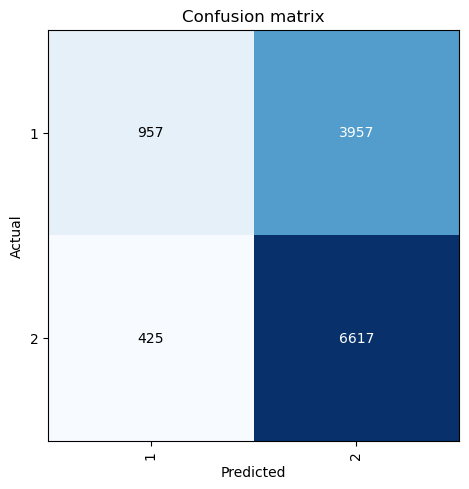

In [32]:
#from the results we see that our accuracy increases marginally and our error rate the same
# Plot a confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [33]:
# Save the model for the Large Part of the assignment
learn.export('model.pkl')

In [34]:
# This will give you the class labels
print(learn.dls.vocab)

[1, 2]


In [36]:
# Suppose the classes were originally 1 = made and 2 = missed
class_mapping = {0: "made", 1: "missed"}


In [42]:
#this is where things get wonky because the predct function works but does not return an expected format for the predicted class so we fix that with the previous line and the label created before reporting results
#regardless we will continue on... in order to test our predicting model we are going to create entries to see varying results

#in the first instance it will be a jumpshot in the second quarter with 2 minutes left and a score margin of 5. PREDICTION: MISSED
#in the second instance it will be a pullup jumpshot in the foruth quarter with 10 seconds left and a score margin of -3. PREDICTION: MISSED
#in the third instance it will be a cutting layup in the first quarter with 10 minutes left and a score margin of 0. PREDICTION: MADE

new_data = pd.DataFrame({
    'EVENTMSGACTIONTYPE': [1,79,98],
    'PERIOD': [2,4,1],
    'SCOREMARGIN': [5.0,-3,0],
    'PCTIMESTRING': [120,10,600]  # Example value in seconds
})

pred_class, pred_idx, outputs = learn.predict(new_data.iloc[0])
# Ensure the predicted class maps correctly
predicted_class_label = class_mapping[int(pred_class['EVENTMSGTYPE'])]
print(f"Predicted class label: {predicted_class_label}")

print(f"Prediction index: {pred_idx}")
print(f"Raw outputs: {outputs}")

Predicted class label: missed
Prediction index: 1
Raw outputs: tensor([0.3346, 0.6654])


/var/folders/c7/tjnc1nv13vl7684g7d2d8thm0000gn/T/ipykernel_4123/1714924551.py:17: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  predicted_class_label = class_mapping[int(pred_class['EVENTMSGTYPE'])]


In [43]:
pred_class, pred_idx, outputs = learn.predict(new_data.iloc[1])
# Ensure the predicted class maps correctly
predicted_class_label = class_mapping[int(pred_class['EVENTMSGTYPE'])]
print(f"Predicted class label: {predicted_class_label}")

print(f"Prediction index: {pred_idx}")
print(f"Raw outputs: {outputs}")

Predicted class label: missed
Prediction index: 1
Raw outputs: tensor([0.3231, 0.6769])


/var/folders/c7/tjnc1nv13vl7684g7d2d8thm0000gn/T/ipykernel_4123/3266013257.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  predicted_class_label = class_mapping[int(pred_class['EVENTMSGTYPE'])]


In [40]:
pred_class, pred_idx, outputs = learn.predict(new_data.iloc[2])
# Ensure the predicted class maps correctly
predicted_class_label = class_mapping[int(pred_class['EVENTMSGTYPE'])]
print(f"Predicted class label: {predicted_class_label}")

print(f"Prediction index: {pred_idx}")
print(f"Raw outputs: {outputs}")

Predicted class label: made
Prediction index: 0
Raw outputs: tensor([0.6739, 0.3261])


/var/folders/c7/tjnc1nv13vl7684g7d2d8thm0000gn/T/ipykernel_4123/2759847564.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  predicted_class_label = class_mapping[int(pred_class['EVENTMSGTYPE'])]
